In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from ROOT import TFile, TH1D


from helpers import *
from gaussfit import *

# Create timeserie for just one pmt

def _getReadout(rr): 
    
    readout=0.01
    
    if rr in [ 5837, 5984, 6001, 6030, 6036, 6069, 6101, 6372, 6232 ]:
        readout=0.03
    elif rr in [ 5260, 5390, 5457, 5573, 5635 ]:
        readout=0.025
    elif rr in [ 5679 ]:
        readout=0.03
    
    return readout # units in this case is kHz 

def pol(x,a, b):
    return a + x*b

def getDfFromRoot(filename, directory="bkgcalibration"):
      
    tfile = TFile.Open(filename, "READ")
    
    if not tfile.cd(directory):
        print("Unknown %s directory in file %s!" % ( directory, filename ))
        return 
    
    tdirectory = tfile.Get(directory)

    #Get the histograms and the pmt number
    histograms = [ tdirectory.Get(key.GetName()) for key in tdirectory.GetListOfKeys()  if "hamplitude" in key.GetName() ]
    pmt = np.array([ int(key.GetName().split("hamplitude")[-1]) for key in tdirectory.GetListOfKeys()  if "hamplitude" in key.GetName() ])

    # Bin 6 should correspond to 2.1 mV

    all_counts = np.array( [hist.Integral(0, -1) for hist in histograms ])
    thr_counts = np.array([ hist.Integral(4, -1) for hist in histograms ])
    
    #keep only valid entries
    sel_good = np.where( all_counts>0 )
    
    runval = [ entry.run for entry in tdirectory.Get("event")][0]
    run = np.full( len(pmt[sel_good]), runval )
    events = np.full( len(pmt[sel_good]), tdirectory.Get("event").GetEntries()  )
    
    readouts = [ _getReadout(rr) for rr in run ]
    
    ratio = thr_counts[sel_good] / ( events * readouts )
    eratio = np.sqrt(thr_counts[sel_good]) / ( events * readouts )
     
    df = pd.DataFrame({'pmt' : pmt[sel_good], "run" : run, "events" : events, "counts":all_counts[sel_good], "counts_thr":thr_counts[sel_good], "ratio": ratio, "eratio":eratio} )
    
    timestamp = [ entry.timestamp for entry in tdirectory.Get("event")][0]
    
    df["timestamp"] = timestamp
    df.set_index("timestamp", inplace=True)
     
    return df


path="../histograms/"
data = pd.concat([ getDfFromRoot(path+filename) for filename in os.listdir(path) if ".root" in filename ])

geo=readSqlitedb()
data = correctMapping( data, geo, [ 1620868988, 1622314102, 1624231164, 1624628760, 1626715902 ] )
data = data.sort_index()

#Swap pmt 42 and pmt 51 for the data collected after may
data.loc[1620868988:1626715902, 'pmt']=data.loc[1620868988:1626715902, 'pmt'].replace([42, 51], [51,42])


Welcome to JupyROOT 6.22/08


KeyError: 1620868988

In [1]:
# Rates only for a specific run
sdf = getDfFromRoot("../histograms/pulseDistributionHist_run5076.root")

print(sdf)


NameError: name 'getDfFromRoot' is not defined

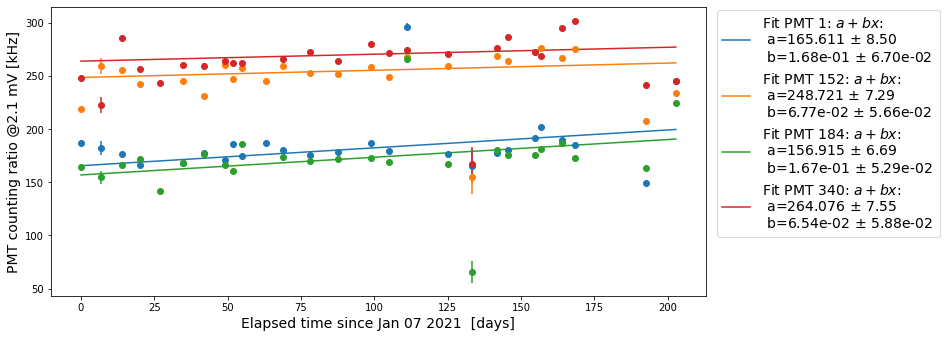

In [67]:
def pmt_gain_timeserie( df, pmt, targets=[ "q", "eq"] ):

    SEL_PMT=df.pmt==pmt
    
    tmin = np.min(df[SEL_PMT].index)
    elapsedTime = np.array([ (t-tmin) / (3600*24) for t in df[SEL_PMT].index ]) #in days
    q = np.array(df[SEL_PMT][targets[0]])
    eq = np.array(df[SEL_PMT][targets[1]])
    run = np.array( df[SEL_PMT].run )  
        
    if len(q) == 0: 
        print(this)
        return elapsedTime, q, eq,  [-99, -99], [-99, 99] 
    
    sel_pos = np.where(q!=0)
    
    params,pcov = curve_fit(pol, elapsedTime[sel_pos] , q[sel_pos], sigma=eq[sel_pos] , p0=[ 0.5, +0.08 ] )
    
    return elapsedTime, q, eq, params, np.diag(pcov)**0.5, run





fig, ax = plt.subplots(1,1, figsize=(10, 4.8))


tmin = np.min(data.index)


for PMT in [1, 152, 184, 340]:

        time, gain, error, params, perrors, run = pmt_gain_timeserie( df=data, pmt=PMT, targets=[ "ratio", "eratio"] )
        out = ax.errorbar( x=time, y=gain, yerr=error, fmt='o')
        
        #for i, tt in enumerate(time):
        #    ax.annotate(xy=(tt, gain[i]), text=run[i], fontsize=11)
        
        ax.plot( time, [ pol( t, *params ) for t in time ], color=out[0].get_color(), label="Fit PMT %d: $a+bx$: \n a=%.3f $\pm$ %.2f \n b=%.2e $\pm$ %.2e " % (PMT, params[0], perrors[0], params[1], perrors[1] ) )

        ax.set_ylabel("PMT counting ratio @2.1 mV [kHz]", fontsize=14)
        ax.set_xlabel( "Elapsed time since %s  [days]" % datetime.fromtimestamp(tmin).strftime("%b %d %Y"), fontsize=14  )
        #ax.set_ylim( (0.45, 0.75)  )
        
fig.legend(bbox_to_anchor=[1.32,0.98], fontsize=14) 
fig.tight_layout()
fig.savefig("selected_pmt_ratio_timeserie_fit.png")
plt.show()

In [37]:
fit_results = []

for pmt in range(0, 360):

    if pmt in [ 70, 106, 217]: 
        continue
    
    _,_,_, params, perrors,_ = pmt_gain_timeserie( df=data, pmt=pmt, targets=[ "ratio", "eratio"] )
    fit_results.append( [pmt, params[0], perrors[0], params[1], perrors[1]] ) 
    
fit_results = np.array( fit_results )

array([<AxesSubplot:xlabel='PMT Number', ylabel='Fitted ratio variation [kHz/day ]'>,
       <AxesSubplot:xlabel='Fitted ratio variation [kHz/day ]'>],
      dtype=object)

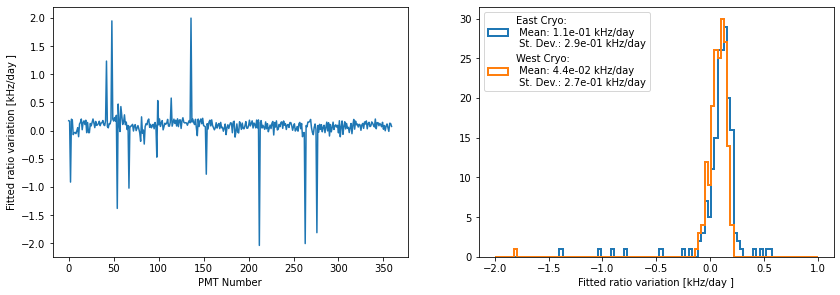

In [65]:
def overviewFitPlot( fit_results, setrange=(-2.0, 1.0), setbins=100 ):

    fig, ax = plt.subplots(1,2, figsize=(14, 4.6))

    ax[0].plot( fit_results[:,0], fit_results[:,3]  )
    #ax[0].set_ylim( (-2e-03, 1e-03) )
    ax[0].set_xlabel( "PMT Number" )
    ax[0].set_ylabel( "Fitted ratio variation [kHz/day ]" )

    ax[1].hist( fit_results[0:180,3], range=setrange, bins=setbins, histtype='step', lw=2, label="East Cryo:\n Mean: %.1e kHz/day \n St. Dev.: %.1e kHz/day" % (np.mean(fit_results[0:180,3]), np.std(fit_results[0:180,3]) )  )
    ax[1].hist( fit_results[180:360,3], range=setrange, bins=setbins, histtype='step', lw=2, label="West Cryo:\n Mean: %.1e kHz/day \n St. Dev.: %.1e kHz/day" % (np.mean(fit_results[180:360,3]), np.std(fit_results[180:360,3]) )  )
    
    ax[1].set_xlabel( "Fitted ratio variation [kHz/day ]")
    ax[1].legend(loc='upper left')

    return ax

overviewFitPlot( fit_results )
